# Nonlinear regression task: Puma 560 robot dynamics simulation
The **pumadyn** datasets are a family of datasets syntheticaly generatd from a realistic simulation of a Puma 560 robot arm. The associated task consists of predicting the angular acceleration of one of the links of the robot arm, given the angular position, velocities, torques, and in some cases other dynamic parameters of the robot arm.
There are 8 different datasets. Here we use pumadyn-32nm, with 32 input features, strongly nonlinear model, and moderate output noise added.
For easier handling, the names of the 32 features have been stored in a separate header file called **Dataset.names**, while the data themselves (32 inputs and one corresponding output for 8192 observations) are in **Dataset.data**. 

In [1]:
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as im
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model

Using TensorFlow backend.


Here we have a look at a photo and a technical drawing of the PUMA-560 robotic arm.

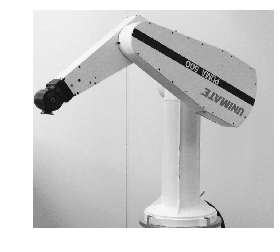

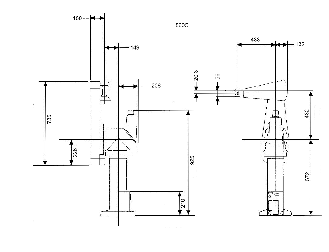

In [2]:
# Show robot
plt.imshow(im.imread('The-PUMA-560-robotic-arm.jpg'),cmap='Greys_r')
plt.axis('off')
plt.bbox_inches=0
plt.show()
plt.imshow(im.imread('puma-560C-drawing.png'))
plt.axis('off')
plt.bbox_inches=0
plt.show()

Reading and preprocessing the data:

In [3]:
# read data
puma=pd.read_csv('Dataset.data',delim_whitespace=True,header=None)

# read column names and apply them to data frame
pumavars=pd.read_csv('Dataset.names',delim_whitespace=True,header=None)
puma.columns = pumavars[1]

# extract and normalize inputs (first 32 cols)
data = puma.iloc[:,0:32]
for i in range(0,data.shape[1]):
  data.loc[:,i] = (data.iloc[:,i]-data.iloc[:,i].min())/(data.iloc[:,i].max()-data.iloc[:,i].min())

# extract and normalize targets (last col)
targets = puma.iloc[:,-1]
targets=(targets-targets.min())/(targets.max()-targets.min())

Setting up  the network:

In [4]:
# build neural network architecture
model = Sequential()
model.add(Dense(512, activation='sigmoid', input_dim=data.shape[1]))
#model.add(Dense(128, activation='sigmoid'))
model.add(Dense(64, activation='sigmoid'))
#model.add(Dense(32, activation='sigmoid'))
model.add(Dense(16, activation='sigmoid'))
model.add(Dense(1, activation='linear'))
opt = optimizers.adam(lr=0.001, decay=1e-6)
es = EarlyStopping(patience=10,restore_best_weights=True) # see below for explanation
model.compile(optimizer=opt, loss='mse')

# Set fixed seed for reproducibility
np.random.seed(1)

Instructions for updating:
Colocations handled automatically by placer.


Training the network:

In [5]:
# Train the model
history = model.fit(data, targets, validation_split=0.2, epochs=50, batch_size=10, callbacks=[es])

# Get the outputs corresponding to all the data
outputs = model.predict(data)

Instructions for updating:
Use tf.cast instead.
Train on 6553 samples, validate on 1639 samples
Epoch 1/50
6553/6553 [==============================] - 2s 309us/step - loss: 0.0264 - val_loss: 0.0228
Epoch 2/50
6553/6553 [==============================] - 1s 187us/step - loss: 0.0240 - val_loss: 0.0249
Epoch 3/50
6553/6553 [==============================] - 1s 191us/step - loss: 0.0237 - val_loss: 0.0228
Epoch 4/50
6553/6553 [==============================] - 1s 179us/step - loss: 0.0235 - val_loss: 0.0229
Epoch 5/50
6553/6553 [==============================] - 1s 180us/step - loss: 0.0233 - val_loss: 0.0230
Epoch 6/50
6553/6553 [==============================] - 2s 230us/step - loss: 0.0230 - val_loss: 0.0230
Epoch 7/50
6553/6553 [==============================] - 1s 201us/step - loss: 0.0225 - val_loss: 0.0209
Epoch 8/50
6553/6553 [==============================] - 1s 182us/step - loss: 0.0180 - val_loss: 0.0107
Epoch 9/50
6553/6553 [==============================] - 1s 193us/step - 

Taking a look at the network:

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               33280     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_3 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 67,169
Trainable params: 67,169
Non-trainable params: 0
_________________________________________________________________


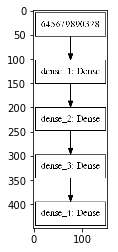

In [6]:
# print summary data
model.summary()

# Generate graphic representation and show it
filename = 'pumagraph.png'
plot_model(model, to_file=filename)
plt.imshow(im.imread(filename),cmap='Greys_r')
plt.show()

Evaluating the network performance:

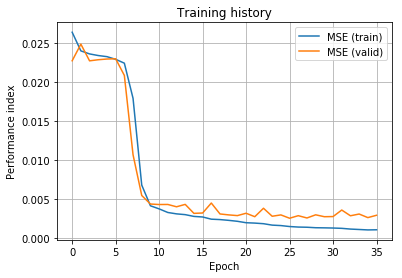

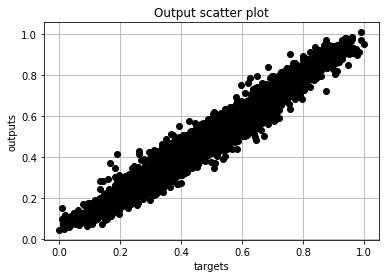

In [7]:
# Plot training & validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training history')
plt.ylabel('Performance index')
plt.xlabel('Epoch')
plt.legend(['MSE (train)', 'MSE (valid)'], loc='upper right')
plt.grid()
plt.show()

# Plot target-output relationship (ideal: targets == outputs, straight line)
plt.plot(targets,outputs,'ok')
plt.title('Output scatter plot')
plt.xlabel('targets')
plt.ylabel('outputs')
plt.grid()
plt.show()

The best performing configuration was found at the epoch corresponding to the minimum validation value; after that the network starts to overfit. The epoch with minimum validation loss is:

In [8]:
validation_stop_epoch = np.array(history.history['val_loss']).argmin()
print(validation_stop_epoch)

25


So we can estimate this model to have an expected RMS error of about

In [9]:
print('%.2E' % history.history['val_loss'][validation_stop_epoch])

2.59E-03


for data mapped on a scale of $[-1,1]$.

### How we used early stopping

The function 'EarlyStopping' automatically stops the training when the validation error does not decrease.

This is a ***callback*** function, one that is called periodically during training. Like for the optimisation function, we create a variable ***es*** containing the EarlyStopping function along with some arguments, pass it to the fit function as an argument, and it will be automatically used by the training.

Since we are using stochastic optimisation (minibatch size = 10 over a training set of thousands of observations) the validation error will oscillate randomly. So before deciding that we should stop, we should have some patience and wait some epochs to see if the lack of improvement is due to stochastic oscillations or is an actual average trend. This is why we set the 'patience' argument to a pretty high value of 10.

On the other hand, after 10 epochs the network might already have gone into overfitting. With this combination of training set size and minibatch size, an epoch consists of about 650 weight updates! So we also set the parameter 'restore_best_weights' to True, so that we can roll back the network at the beginning of the observation period, when the optimal value was observed.

There are other arguments to the EarlyStopping function, but their default values were OK for us, so we did not set them.